# Photometric reduction

After an observation is done, a common need is to reduce and extract fluxes from raw FITS images. 

In this tutorial you will learn how to process a complete night of raw data from any telescope with some basic reduction tools provided by *prose*.

## Example data

You can follow this tutorial on your own data or generate a synthetic dataset. As an example, let's generate a light curve

(0.98, 1.02)

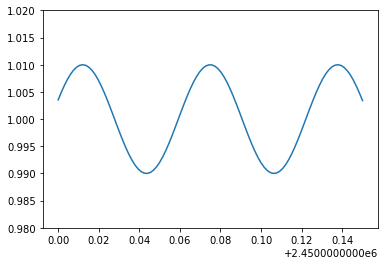

In [1]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 0.15, 100) + 2450000
target_dflux = 1 + np.sin(time*100)*1e-2

plt.plot(time, target_dflux)
plt.ylim(0.98, 1.02)

This might be the differential flux of a variable star. Let's now simulate the fits images associated with the observation of this target:

In [2]:
from prose.tutorials import simulate_observation

# so we have the same data
np.random.seed(40)

fits_folder = "./tutorial_dataset"
simulate_observation(time, target_dflux, fits_folder)

here prose simulated comparison stars, there fluxes over time and some systematics noises.

## Telescope setting

We start by setting up the `Telescope` information we need for the reduction, for example some fits keywords that are specific to this observatory plus few specs:

In [3]:
from prose import Telescope

_ = Telescope({
    "name": "A",
    "trimming": [40, 40],
    "pixel_scale": 0.66,
    "latlong": [31.2027, 7.8586],
    "keyword_light_images": "light"
})

Telescope 'a' saved


This has to be done **only once** and saves this telescope settings for any future use (whenever its name appears in fits headers). More details are given in the [telescope settings](../api/telescope.rst) note.

## Folder exploration

The first thing we want to do is to see what is contained within our folder. For that we instantiate a `FitsManager` object on our folder to describe its content

In [4]:
from prose import FitsManager

fm = FitsManager(fits_folder, depth=2)
print(fm)

RUN Parsing FITS: 100%|██████████████████| 106/106 [00:00<00:00, 794.87images/s]

╒═════════╤════════════╤═════════════╤══════════╤══════════╤════════╤════════════╕
│   index │ date       │ telescope   │ target   │ filter   │ type   │   quantity │
╞═════════╪════════════╪═════════════╪══════════╪══════════╪════════╪════════════╡
│       0 │ 2022-06-10 │ A           │ prose    │ a        │ light  │        100 │
╘═════════╧════════════╧═════════════╧══════════╧══════════╧════════╧════════════╛
Calibrations:
╒════════════╤═════════════╤══════════╤══════════╤════════╤════════════╕
│ date       │ telescope   │ target   │ filter   │ type   │   quantity │
╞════════════╪═════════════╪══════════╪══════════╪════════╪════════════╡
│ 2022-06-10 │ A           │ prose    │          │ bias   │          1 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2022-06-10 │ A           │ prose    │          │ dark   │          1 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2022-06-10 │ A           │ prose    │ a        │ flat   │ 

We have 100 images of the *prose* target together with some calibration files. More info about the `FitsManager` object [here](./fits_manager.ipynb).

## Choosing a reference image

In order to perform the photometric extraction on all images, we will select a reference image

In [5]:
from prose import Image

# image 0 will be our reference
ref = Image(fm.images[0])

and apply the following sequence to get the stars we want to perform photometry on

INFO Building master bias
INFO Building master dark
INFO Building master flat


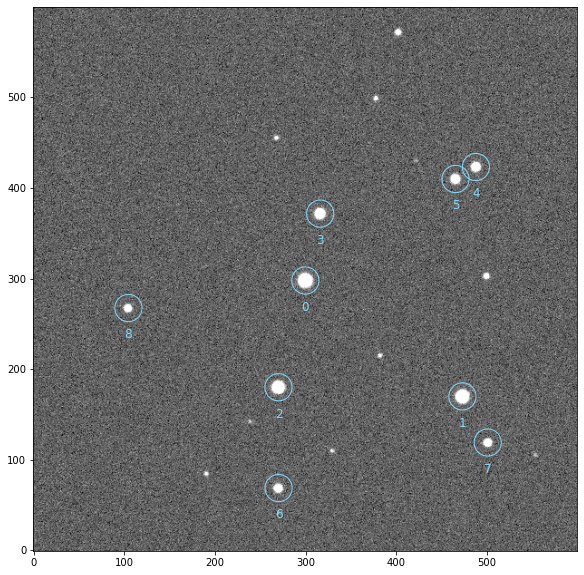

In [6]:
from prose import Sequence, blocks

calibration = Sequence([
    blocks.Calibration(darks=fm.darks, bias=fm.bias, flats=fm.flats),
    blocks.SegmentedPeaks(), # stars detection
    blocks.Cutouts(),                   # making stars cutouts
    blocks.MedianPSF(),                 # building PSF
    blocks.Moffat2D(),                  # modeling PSF
])

calibration.run(ref, show_progress=False)
ref.show()

.. note:
    
    You can use a Gaia query to define which stars you want the photometry from (e.g. if too faint to be detected here)

## Photometry

We can now extract the photometry of these stars

In [7]:
photometry = Sequence([
    *calibration,                         # apply the same calibration to all images
    blocks.detection.LimitStars(min=3),   # discard images not featuring enough stars
    blocks.Twirl(ref.stars_coords),       # compute image transformation
    
    # set stars to the reference ones and apply the inverse 
    # transformation previously found to match the ones in the image
    blocks.Set(stars_coords=ref.stars_coords),
    blocks.AffineTransform(data=False, inverse=True),
    
    blocks.BalletCentroid(),                            # stars centroiding
    blocks.PhotutilsAperturePhotometry(scale=ref.fwhm), # aperture photometry
    blocks.Peaks(),
    
    # Retrieving data from images in a conveniant way (see later)
    blocks.XArray(
        ("time", "jd_utc"),
        ("time", "bjd_tdb"),
        ("time", "flip"),
        ("time", "fwhm"),
        ("time", "fwhmx"),
        ("time", "fwhmy"),
        ("time", "dx"),
        ("time", "dy"),
        ("time", "airmass"),
        ("time", "exposure"),
        ("time", "path"),
        (("time", "apertures", "star"), "fluxes"),
        (("time", "apertures", "star"), "errors"),
        (("time", "apertures", "star"), "apertures_area"),
        (("time", "apertures", "star"), "apertures_radii"),
        (("time", "star"), "sky"),
        (("time", "apertures"), "apertures_area"),
        (("time", "apertures"), "apertures_radii"),
        ("time", "annulus_rin"),
        ("time", "annulus_rout"),
        ("time", "annulus_area"),
        (("time", "star"), "peaks"),
        name="xarray"
    ),
    
    # Stack image
    blocks.AffineTransform(stars=False, data=True),
    blocks.Stack(ref, name="stack"),
])

photometry.run(fm.images)

RUN 100%|█████████████████████████████████| 100/100 [00:12<00:00,  8.31images/s]


All our data lie in the `blocks.Xarray` block, that we will transform into a convenient `Observation` object

In [8]:
from prose import Observation

obs = Observation(photometry.xarray.to_observation(photometry.stack.stack, sequence=photometry))

INFO Time converted to BJD TDB


## Photometry analysis

To show the stack image of the observation and see what `obs` contains:

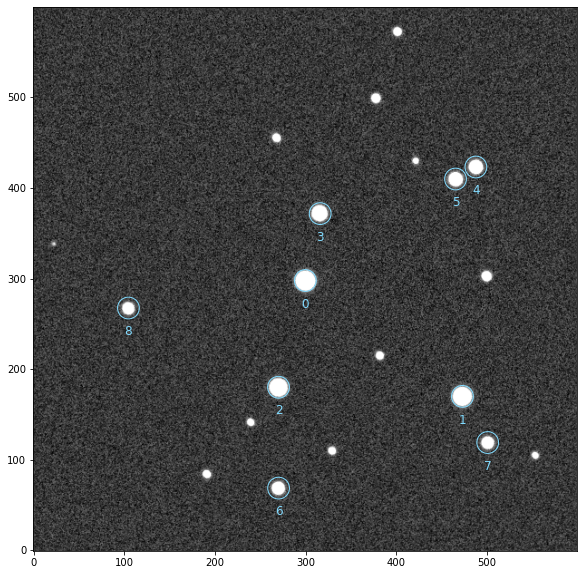

In [9]:
obs.show_stars(size=8)

In [10]:
obs

<div class="alert alert-info">

Note

More details on the structure of these data products (and the representation above) in [data products description](./phot.ipynb)

</div>

If target was not specified in the reduction process, we need to specify it before producing our differential Photometry.

(0.98, 1.02)

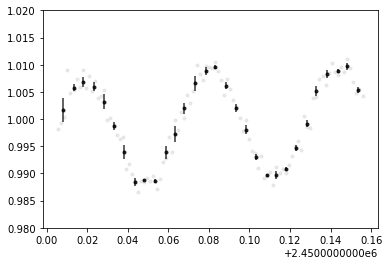

In [11]:
obs.target = 0
obs.broeg2005()
obs.plot()
plt.ylim(0.98, 1.02)

<div class="alert alert-info">

Note

We could also have picked the comparison stars ourselves using ``diff`` from `Observation`

</div>

We used the Broeg 2005 algorithm to build the differential light-curve and ended by plotting it. We can check the comparison stars with

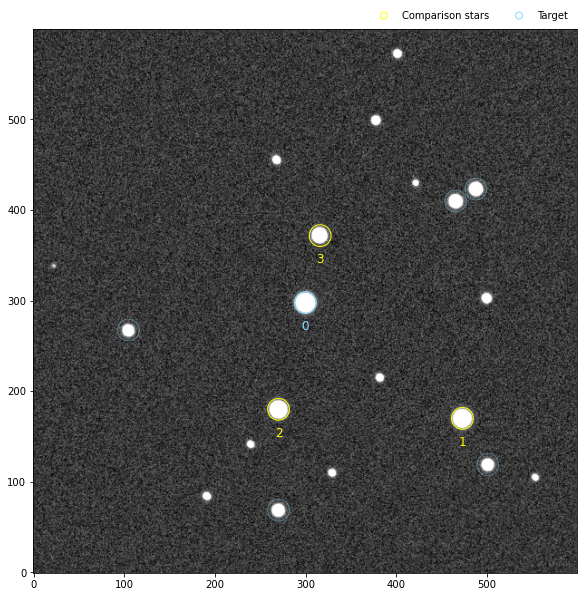

In [12]:
obs.show_stars(size=8)

and continue with further visualisation or analysis. All available plotting and analysis methods are described in `Observation`.

To save your analysis into the same phot file

In [13]:
obs.save(f"{obs.label}.phot")

INFO saved /Users/lgrcia/code/prose-docs/source/notebooks/A_20220610_prose_a.phot


## Some more details

### `Observation` plots

From the `Observation` object many things can be plotted. For example here are the comparison light curves as well as the systematics data:

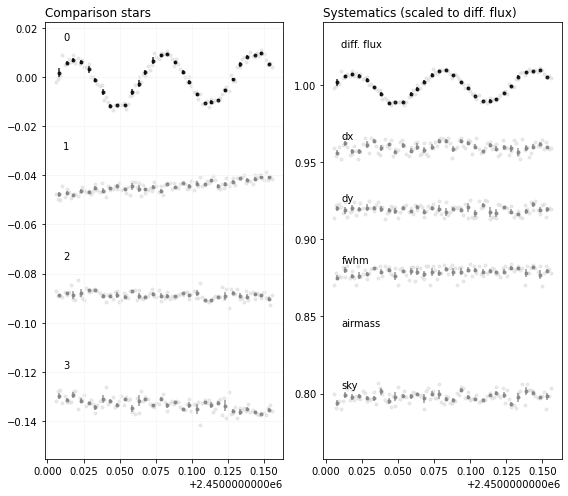

In [14]:
plt.figure(figsize=(8, 7))

plt.subplot(121)
obs.plot_comps_lcs()

plt.subplot(122)
obs.plot_systematics()

here is another useful one showing the raw fluxes as well as the artificial light curve (a weighted mean of the comparison stars - see Broeg 2005 paper)

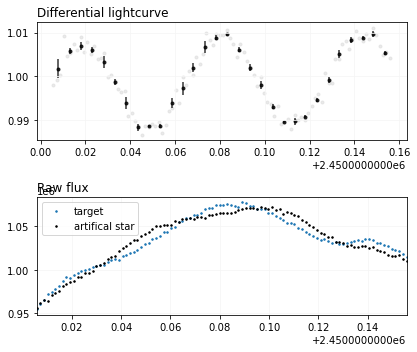

In [15]:
plt.figure(figsize=(6, 5))
obs.plot_raw_diff()

To see all possible plotting options check the `Observation` API